# In this notebook the code is developed to solve the VeRoLog solver challenge to optimality. mip is used to create and execute the created MILP. We use the example instance of the VeRoLog challenge since it is rather small. The index of some variables have been moved by 1 since python starts indexing at 0. The formulas in this notebook are written with LaTeX. In mip strict inequalities are not supported

## Imports

In [2]:
import logging
import math as math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import time
import mip as mip
#import multiprocessing

In [3]:
logging.basicConfig(filename='VeRoLog MILP', level=logging.INFO,format='%(asctime)s:%(levelname)s:%(message)s')
opt_model = mip.Model(name='VeRoLog',solver_name=mip.CBC)

## Input parameters (the variable used in the formulas are commented next to the variable)

In [4]:
DAYS = 7                                                #T
technicians = [0,1,2,3,4]                                #H
trucks = [i for i in range(3)]                        #K (arbitrarily chosen)
machines = [0,1,2,3]                                         #M
customers = [i for i in range(7)]                    #C

customer_machine_types = [0,2,3,0,1,3,1]           #m_j
machine_size = [2,1,3,2]                                     #s_{m_j}
machine_penalty = [200,200,500,100]                              #pi_j
customer_order_size = [1,1,2,3,1,1,4]              #d_j
start_delivery_window = [0,2,1,4,0,0,2]              #a_j
end_delivery_window =  [6,5,2,6,3,5,4]              #b_j
technician_max_visits = [2,1,5,2,1]                      #r_h
technician_max_distance = [100,100,100,100,50]     #omega_h
technician_skill_set = [[0,1,1,1],[1,1,0,0],[0,0,1,0],[1,1,0,1],[1,1,1,1]]   #g_{h_m}
TRUCK_MAX_DISTANCE = 250                                #delta
TRUCK_CAPACITY = 6                                      #Q
LARGE_NUMBER = 1000                                      #L

TRUCK_DISTANCE_COST = 1                               #beta
TRUCK_DAY_COST = 100                                  #alpha
TRUCK_COST = 100000                                       #gamma
TECHNICIAN_DISTANCE_COST = 1                           #phi
TECHNICIAN_DAY_COST = 100000                              #lambda
TECHNICIAN_COST = 100   

In [5]:
# # Alternative to test the consecutive working days constraint
# DAYS = 12                                                #T
# technicians = [0,1]                                #H
# trucks = [i for i in range(3)]                        #K (arbitrarily chosen)
# machines = [0,1,2,3]                                         #M
# customers = [i for i in range(15)]                    #C

# customer_machine_types = [0,2,3,0,1,3,1,3,1,2,0,0,3,2,0]           #m_j
# machine_size = [2,1,3,2]                                     #s_{m_j}
# machine_penalty = [200,200,500,100]                              #pi_j
# customer_order_size = [1,1,2,3,1,1,4,1,1,1,1,1,1,1,1]              #d_j
# start_delivery_window = [0,2,1,4,0,0,2,0,2,1,4,0,0,2,0]              #a_j
# end_delivery_window =  [6,5,2,6,3,5,4,6,5,2,6,3,5,4,5]              #b_j
# technician_max_visits = [2,1]                      #r_h
# technician_max_distance = [200,300]     #omega_h
# technician_skill_set = [[1,0,0,1],[1,1,1,1]]   #g_{h_m}
# TRUCK_MAX_DISTANCE = 250                                #delta
# TRUCK_CAPACITY = 6                                      #Q
# LARGE_NUMBER = 1000                                      #L

# TRUCK_DISTANCE_COST = 1                               #beta
# TRUCK_DAY_COST = 100                                  #alpha
# TRUCK_COST = 100000                                       #gamma
# TECHNICIAN_DISTANCE_COST = 1                           #phi
# TECHNICIAN_DAY_COST = 100000                              #lambda
# TECHNICIAN_COST = 100                                     #mu

### Graph $G=(N,E)$

In [6]:
def tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types):
    """
    Purpose,
        Create a graph that includes the technician node and all the customer location where the technician can install
    Input,
        h, int: technician under consideration
        technician_skill_set, list: the skillset of each technician
        technician_nodes, dict: nodes of technicians
        customer_nodes, dict: nodes of customers
        customer_machine_types, list: machine type of each customer order/request
    Output,
        G_tech_h, networkx DiGraph for technician h
    """
    G_tech_h = nx.DiGraph()
    G_tech_h.add_nodes_from({key: technician_nodes[key] for key in [len(customer_nodes)+1+h]})
    
    customers_to_add = []
    for i in customer_nodes:
        if technician_skill_set[h][customer_machine_types[i-1]]:
            customers_to_add.append(i)
    
    G_tech_h.add_nodes_from({key: customer_nodes[key] for key in customers_to_add})
    
    return G_tech_h
# G_test = tech_graph(3,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
# print(G_test.nodes)

In [7]:
#nodes: dictionary of x and y coordinates
depot_node = {0:(10,50)}
customer_nodes = {1:(20, 10),2:(50, 5),3:(33, 7),4:(40, 40),5:(70,40),6:(1, 35),7:(1, 35)}   #\mathcal{C}
technician_nodes = {8:(50,5),9:(10,5),10:(10,5),11:(25,60),12:(10,50)}                       #\mathcal{H}
nodes = {**depot_node,**customer_nodes,**technician_nodes}                                   #N
x_nodes = {**depot_node,**customer_nodes}                                                    #N_x
#y_nodes = {**customer_nodes,**technician_nodes}                                              #N_y
number_of_nodes = len(nodes)
#edges and cost
count_0 = 0
count_1 = 0
# we first want the edges that connect the depot to each customer and each customer to each customer, the graph is directed
edges_index = {}                                                                            #E
cost_edges = [[] for i in nodes]
for i in x_nodes:
    count_1 = 0
    for j in x_nodes:
        if i!=j:
            edges_index[(i,j)] = (count_0,count_1)
            cost_edges[i].append(math.ceil(math.sqrt((x_nodes[i][0] - x_nodes[j][0])**2+(x_nodes[i][1]-x_nodes[j][1])**2)))
            count_1 +=1
    count_0 +=1
# # we now want to connect the technician home locations to each customer where it can install
for h in technicians:
    tech_node = h+len(customer_nodes)+1
    G_tech_h = tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
    G_tech_h.remove_node(tech_node)
    count_1 = 0
    for cust_node in G_tech_h.nodes:
        edges_index[(tech_node,cust_node)] = (count_0,count_1)
        edges_index[(cust_node,tech_node)] = (count_0,count_1+1)
        cost_edges[tech_node].append(math.ceil(math.sqrt((technician_nodes[tech_node][0]-customer_nodes[cust_node][0])**2+(technician_nodes[tech_node][1]-customer_nodes[cust_node][1])**2)))
        cost_edges[tech_node].append(math.ceil(math.sqrt((customer_nodes[cust_node][0]-technician_nodes[tech_node][0])**2+(customer_nodes[cust_node][1]-technician_nodes[tech_node][1])**2)))
        count_1 += 2
    count_0 +=1

In [8]:
cost_edges[edges_index[(0, 1)][0]][edges_index[(0, 1)][1]]

42

In [9]:
cost_edges

[[42, 61, 49, 32, 61, 18, 18],
 [42, 31, 14, 37, 59, 32, 32],
 [61, 31, 18, 37, 41, 58, 58],
 [49, 14, 18, 34, 50, 43, 43],
 [32, 37, 37, 34, 30, 40, 40],
 [61, 59, 41, 50, 30, 70, 70],
 [18, 32, 58, 43, 40, 70, 0],
 [18, 32, 58, 43, 40, 70, 0],
 [0, 0, 18, 18, 41, 41, 58, 58, 58, 58],
 [12, 12, 47, 47, 70, 70, 32, 32],
 [40, 40],
 [51, 51, 54, 54, 25, 25, 50, 50, 35, 35, 35, 35],
 [42, 42, 61, 61, 49, 49, 32, 32, 61, 61, 18, 18, 18, 18]]

In [10]:
# # Alternative to test the consecutive working days constraint
# #nodes: dictionary of x and y coordinates
# depot_node = {0:(10,50)}
# customer_nodes = {1:(20, 10),2:(50, 5),3:(33, 7),4:(40, 40),5:(70,40),6:(1, 35),7:(1, 35),
#                   8:(20, 10),9:(50, 5),10:(33, 7),11:(40, 40),12:(70,40),13:(1, 35),14:(1, 35),15:(50,60)}   #\mathcal{C}
# technician_nodes = {16:(50,5),17:(10,5)}                       #\mathcal{H}
# nodes = {**depot_node,**customer_nodes,**technician_nodes}                                   #N
# x_nodes = {**depot_node,**customer_nodes}                                                    #N_x
# y_nodes = {**customer_nodes,**technician_nodes}                                              #N_y
# number_of_nodes = len(nodes)
# #edges and cost: every node is connected and the graph is directed
# count_0 = 0
# count_1 = 0
# # we first want the edges that connect the depot to each customer and each customer to each customer, the graph is directed
# edges_index = {}                                                                            #E
# cost_edges = [[] for i in nodes]
# for i in x_nodes:
#     count_1 = 0
#     for j in x_nodes:
#         if i!=j:
#             edges_index[(i,j)] = (count_0,count_1)
#             cost_edges[i].append(math.ceil(math.sqrt((x_nodes[i][0] - x_nodes[j][0])**2+(x_nodes[i][1]-x_nodes[j][1])**2)))
#             count_1 +=1
#     count_0 +=1
# # # we now want to connect the technician home locations to each node
# for tech_node in technician_nodes:
#     count_1 = 0
#     for cust_node in customer_nodes:
#         edges_index[(tech_node,cust_node)] = (count_0,count_1)
#         edges_index[(cust_node,tech_node)] = (count_0,count_1+1)
#         cost_edges[tech_node].append(math.ceil(math.sqrt((technician_nodes[tech_node][0]-customer_nodes[cust_node][0])**2+(technician_nodes[tech_node][1]-customer_nodes[cust_node][1])**2)))
#         cost_edges[tech_node].append(math.ceil(math.sqrt((customer_nodes[cust_node][0]-technician_nodes[tech_node][0])**2+(customer_nodes[cust_node][1]-technician_nodes[tech_node][1])**2)))
#         count_1 += 2
#     count_0 +=1

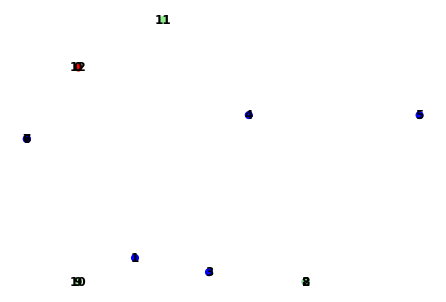

In [11]:
#create and plot the graph with networkx
G_cust = nx.DiGraph()
G_tech = nx.DiGraph()
G_depot = nx.DiGraph()

G_cust.add_nodes_from(customer_nodes)
G_tech.add_nodes_from(technician_nodes)
G_depot.add_nodes_from(depot_node)

pos = {}
for node in G_cust.nodes:
    pos[node] = nodes[node]
for node in G_tech.nodes:
    pos[node] = nodes[node]
for node in G_depot.nodes:
    pos[node] = nodes[node]
    
plt.figure(figsize=[6,4])
nx.draw(G_cust,pos=pos, node_size=50, with_labels=True, font_weight='bold',node_color=["blue" for c in customers])
nx.draw(G_tech,pos=pos, node_size=50, with_labels=True, font_weight='bold',node_color=["lightgreen" for tech in technicians])
nx.draw(G_depot,pos=pos,node_size=50, with_labels=True, font_weight='bold',node_color=['red'])
plt.show()

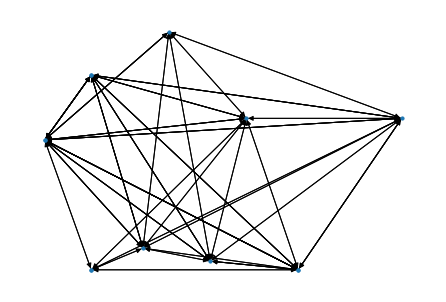

In [12]:
#with edges
G = nx.DiGraph()
for k,v in edges_index.items():
    G.add_edge(*k)
    
plt.figure(figsize=[6,4])
nx.draw(G,pos=pos, node_size=10)
plt.show()

## Data checks

In [13]:
cost_edges

[[42, 61, 49, 32, 61, 18, 18],
 [42, 31, 14, 37, 59, 32, 32],
 [61, 31, 18, 37, 41, 58, 58],
 [49, 14, 18, 34, 50, 43, 43],
 [32, 37, 37, 34, 30, 40, 40],
 [61, 59, 41, 50, 30, 70, 70],
 [18, 32, 58, 43, 40, 70, 0],
 [18, 32, 58, 43, 40, 70, 0],
 [0, 0, 18, 18, 41, 41, 58, 58, 58, 58],
 [12, 12, 47, 47, 70, 70, 32, 32],
 [40, 40],
 [51, 51, 54, 54, 25, 25, 50, 50, 35, 35, 35, 35],
 [42, 42, 61, 61, 49, 49, 32, 32, 61, 61, 18, 18, 18, 18]]

In [14]:
if not len(technicians) == len(technician_nodes) == len(technician_max_visits) == len(technician_max_distance) == len(technician_skill_set):
    logging.error("ERROR: the technician data is not consistent")

if not len(customer_machine_types) == len(customer_order_size) == len(start_delivery_window) == len(end_delivery_window) ==len(customer_nodes) == len(customers):
    logging.error("ERROR: the customer data is not consistent")

if not len(machines) == len(machine_size) == len(machine_penalty):
    logging.error("ERROR: the machine data is not consistent")

for i in range(len(customer_nodes)):
    if start_delivery_window[i] < 0:
        logging.error("ERROR: the start of delivery window is smaller than 0")
    if start_delivery_window[i] >= end_delivery_window[i]:
        logging.error("ERROR: the start of delivery window is larger or equal than the end")
    if end_delivery_window[i] == DAYS-1:
        end_delivery_window[i] = end_delivery_window[i]-1 #one day is needed to install within horizon so might as well shift it
    if end_delivery_window[i] > DAYS-1:
        logging.error("ERROR: the end of delivery window is outside horizon")

for i in range(len(customer_nodes)):
    if 2*cost_edges[0][i]> TRUCK_MAX_DISTANCE:
        logging.error("ERROR: trucks can't reach customer {0}".format(i))

for i, machine_type in enumerate(customer_machine_types):
    if machine_size[machine_type] * customer_order_size[i] > TRUCK_CAPACITY:
        logging.error("ERROR: customer order is to large for truck capacity")         

tech_dist_check = [0 for i in customers]
for i in customers:
    MachineType = customer_machine_types[i]
    for tech in technicians:
        if technician_skill_set[tech][MachineType] == 1:
            edge_index = edges_index[(tech+len(customers)+1,i+1)]
            if 2*cost_edges[edge_index[0]][edge_index[1]] < technician_max_distance[tech]:
                tech_dist_check[i] = 1
if min(tech_dist_check) == 0:
    logging.error("ERROR: customer location is located too far from technicians")  

## Decision variables

### We have the following decision variables:
### $x_{tkij} \in \{0,1\} \text{: indicates if on day $t$, truck $k$, drives from node $i$ to $j$}$
### $y_{thij} \in \{0,1\} \text{: indicates if on day $t$, technician $h$, drives from node $i$ to $j$}$
### $u_k \in {\rm I\!R} \text{: indicates if truck $k$ is used in the problem}$
### $v_{tk} \in {\rm I\!R} \text{: indicates if on day $t$ truck $k$ is used}$
### $p_h \in {\rm I\!R} \text{: indicates if technician $h$ is used in the problem}$
### $q_{th} \in {\rm I\!R} \text{:  indicates if on day $t$ technician $h$ is used}$
### $z_{tkj} \in {\rm I\!R} \text{: cumulative load on day $t$, in truck $k$, when delivering to $j \in \mathcal{C}$}$
### $\ell_{thj} \in {\rm I\!R} \text{: decision variable for cumulative load on day $t$, for technician $h$, installing at $j \in \mathcal{C}_h$}$
### $w_{th} \in \{0,1\} \text{: indicates if on day $t$ technician $h$ has worked for 5 days in a row}$
### where
### $ u_k \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} k \in K,                                                 $
### $ v_{tk} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K,                        $
### $ p_h \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} h \in H,                                                $
### $ q_{th} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, $
### $ z_{tkj} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, k \in K, j \in \mathcal{C} $
### $ \ell_{tkj} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, j \in \mathcal{C} $

In [ ]:
type(opt_model)

In [ ]:
# Binary
#no connection between technician homes
#delivery needs to be fullfilled one day before end of the horizon
x = [[[[opt_model.add_var(name="x_{0}_{1}_{2}_{3}".format(t,k,i,j),var_type=mip.BINARY) for j in x_nodes if j != i] for i in x_nodes] for k in trucks] for t in range(DAYS-1)]

#installation can only start one day later than delivery, also no connection between technician homes and depot
# the technicians are disconnected from the customer nodes if their skillset does not allow them to install there
y = [[[]for h in technicians] for t in range(1,DAYS)]
for t in range(DAYS-1):
    for h in technicians:
        count_h = 0
        G_tech_h = tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
        for i in G_tech_h.nodes:
            y[t][h].append([])
            for j in G_tech_h.nodes:
                if i != j:
                    y[t][h][count_h].append(opt_model.add_var(name="y_{0}_{1}_{2}_{3}".format(t+1,h,i,j),var_type=mip.BINARY))
            count_h +=1
            
#technician can only have worked for the past 5 consecutive days on the 7th day in the horizon
if DAYS > 6:
    w = [[opt_model.add_var(name="w_{0}_{1}".format(t,h),var_type=mip.BINARY) for h in technicians] for t in range(6,DAYS)]

# # Continuous
u = [opt_model.add_var(name="u_{0}".format(k),lb=0.0) for k in trucks]

v = [[opt_model.add_var(name="v_{0}_{1}".format(t,k),lb=0.0) for k in trucks] for t in range(DAYS-1)]

p = [opt_model.add_var(name="p_{0}".format(h),lb=0.0) for h in technicians]

q = [[opt_model.add_var(name="q_{0}_{1}".format(t,h),lb=0.0) for h in technicians] for t in range(1,DAYS)]

#delivery needs to be fullfilled one day before end of the horizon
z = [[[opt_model.add_var(name="z_{0}_{1}_{2}".format(t,k,j),lb=0.0) for j in customer_nodes] for k in trucks] for t in range(DAYS-1)]

#installation can only start one day later than delivery
#the load only needs to be calculated for customer nodes that the technician can install
l = [[[]for h in technicians] for t in range(1,DAYS)]
for t in range(DAYS-1):
    for h in technicians:
        G_tech_h = tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
        for j in G_tech_h.nodes:
            if j != len(nodes) - len(technician_nodes) + h: #exclude the technician home
                l[t][h].append(opt_model.add_var(name="l_{0}_{1}_{2}".format(t+1,h,j),lb=0.0)) 

## Objective function

## $\min \beta \sum\limits_{t=0}^{T-1}\sum\limits_{k \in K}\sum_{(i,j) \in E} x_{tkij}c_{ij} + \gamma \sum\limits_{k \in K} u_k + \alpha \sum\limits_{t=0}^{T-1}\sum\limits_{k \in K}v_{tk} + \phi \sum\limits_{t=1}^{T}\sum\limits_{h \in H}\sum\limits_{(i,j) \in E} y_{thij}c_{ij} + \mu \sum\limits_{h \in H} p_{h} + \lambda \sum\limits_{t=1}^{T}\sum\limits_{h \in H} q_{th} + \sum\limits_{j \in \mathcal{C}} \pi_{m_j} d_j \left(\left(\sum\limits_{t=0}^{T-1}\sum\limits_{i \in N} \left( \sum\limits_{h \in H} (t+1) y_{t+1hij} - \sum\limits_{k \in K} t x_{tkij}\right) \right) - 1\right)$

In [ ]:
def calc_edge_cost(var,t,k_h,i,j,edges_index,cost_edges):
    """
    Purpose,
        Calculate the cost to travel an edge given the variable (x or y) and it's index (t,k or h,i,j)
    Input,
        var, mip.Var: the variable we are looking at (x or y)
        t, int: the index of the day
        k_h, int, the index of the truck (k) or the technician (h)
        i, int: the index of the node we are leaving
        j, int: the index of the node we are entering
        edges_index, dict: indicating the index in cost_edges (values) for each edge (keys)
        cost_edges, list: indicating the cost for each edge
    Output,
        edge_cost, cost to travel over this edge
    """
    var_name = var[t][k_h][i][j].name
    var_name_split = var_name.split('_')
    outgoing_node =  int(var_name_split[3])
    incoming_node = int(var_name_split[4])
    edge_index = edges_index[(outgoing_node,incoming_node)]
    edge_cost = cost_edges[edge_index[0]][edge_index[1]]
    
    return edge_cost

In [ ]:
c_truck_distance = TRUCK_DISTANCE_COST * (mip.xsum(x[t][k][i][j] * calc_edge_cost(x,t,k,i,j,edges_index,cost_edges) for t in range(DAYS-1) 
                                for k in trucks for i in range(len(x[t][k])) for j in range(len(x[t][k][i]))))
#print(c_truck_distance)

In [ ]:
c_truck = TRUCK_COST * mip.xsum(u[k] for k in trucks)
# print(c_truck)

In [ ]:
c_truck_day = TRUCK_DAY_COST * mip.xsum(v[t][k] for t in range(DAYS-1) for k in trucks) 
# print(c_truck_day)

In [ ]:
c_tech_distance = TECHNICIAN_DISTANCE_COST * mip.xsum(y[t][h][i][j] * calc_edge_cost(y,t,h,i,j,edges_index,cost_edges)
                                                      for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h]))
                                                      for j in range(len(y[t][h][i]))) 
# print(c_tech_distance)

In [ ]:
c_tech = TECHNICIAN_COST * mip.xsum(p[h] for h in technicians) 
# print(c_tech)

In [ ]:
c_tech_day = TECHNICIAN_DAY_COST * mip.xsum(q[t][h] for t in range(0,DAYS-1) for h in technicians)
# print(c_tech_day)

In [ ]:
# # for the penalization we need to find all nodes that go into the customer node
# selected_customer = 5
# for i in x_nodes:
#     if i > selected_customer:
#         print(x[0][0][i][selected_customer].name)
#     elif i < selected_customer:
#         print(x[0][0][i][selected_customer-1].name)

In [ ]:
# #delivery day for a customer is t multiplied by x_{t}_{k}_{i}_{selected_customer} for all i that are not the selected_customer
# deliv_days_sel_cust = (mip.xsum(t*x[t][k][i][selected_customer] for t in range(DAYS-1) for k in trucks for i in x_nodes if i > selected_customer)
#                        + mip.xsum(t*x[t][k][i][selected_customer-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i < selected_customer))
# print(deliv_days_sel_cust)

In [ ]:
# for j in customer_nodes:
#     print("customer: ",j)
#     g_tech = tech_graph(0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
#     for tech_node in range(len(g_tech.nodes)):
#         for i in range(len(y[0][0][tech_node])):
#             if int(y[0][0][tech_node][i].name.split('_')[4]) == j:
#                 print("The following variable must be added",y[0][0][tech_node][i].name)

In [ ]:
def tech_cust_variables(y,h,selected_customer,t,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types):
    """
    Purpose
        Create a linear expression of all the nodes that go into a selected customer on a day for a technician
    Input
        y, mip.Var: decision variable that indicates if on day t, technician h, drives from node i to j     
        h, int: technician under consideration
        selected_customer, int: customer node under consideration
        t, int: the index of the day
        technician_skill_set, list: the skillset of each technician
        technician_nodes, dict: nodes of technicians
        customer_nodes, dict: nodes of customers
        customer_machine_types, list: machine type of each customer order/request        
    Output
        tech_cust_expr, mip.entities.LinExpr: linear expression that sums all nodes that go into a customer node
    """
    g_tech = tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
    if selected_customer in g_tech.nodes:
        #print(h,selected_customer,t,g_tech.nodes)
        tech_cust_expr = mip.xsum(y[t][h][tech_node][i] for tech_node in range(len(g_tech.nodes)) for i in range(len(
                            y[t][h][tech_node])) if int(y[t][h][tech_node][i].name.split('_')[4]) == selected_customer)
    else:
        tech_cust_expr = mip.xsum(i for i in range(2) if 1 == 0) #return empty sum
    return tech_cust_expr

# print(tech_cust_variables(y,0,3,0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))
# print(tech_cust_variables(y,3,5,1,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))
# print(tech_cust_variables(y,1,1,1,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))

In [ ]:
# #installation day for a customer is t multiplied by y_{t}_{k}_{i}_{selected_customer} for all i that are not the selected_customer
# install_days_sel_cust = (mip.xsum((t+1)*tech_cust_variables(y,h,selected_customer,t,technician_skill_set,technician_nodes,
#                                                       customer_nodes,customer_machine_types) for t in range(DAYS-1) for h in technicians))
# print(install_days_sel_cust)

In [ ]:
# # the difference between the installation day and delivery day for a customer -1 gives the number of penalized days
# penalized_days_sel_cust = (install_days_sel_cust - deliv_days_sel_cust) - 1
# print(penalized_days_sel_cust)

In [ ]:
c_penalty = mip.xsum(machine_penalty[customer_machine_types[j-1]] * customer_order_size[j-1] * 
         ((mip.xsum((t+1)*tech_cust_variables(y,h,j,t,technician_skill_set,technician_nodes,
                                                      customer_nodes,customer_machine_types) for t in range(DAYS-1) for h in technicians))
         -(mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i > j)
         + mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i < j))
         - 1) for j in customer_nodes)
# print(c_penalty)

In [ ]:
type(c_penalty)

In [ ]:
objective_func = c_truck_distance + c_truck + c_truck_day + c_tech_distance + c_tech + c_tech_day + c_penalty
opt_model.objective = mip.minimize(objective_func)

## Constraints

### Decision variable used for calculation

### $u_k - x_{tkij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, (i,j) \in E$

In [ ]:
for t in range(DAYS-1):
    for k in trucks:
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                opt_model += u[k] - x[t][k][i][j] >= 0

### $v_{tk} - x_{tkij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, (i,j) \in E$

In [ ]:
for t in range(DAYS-1):
    for k in trucks:
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                opt_model += v[t][k] - x[t][k][i][j] >= 0

### $p_h - y_{thij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, (i,j) \in E$

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        for i in range(len(y[t][h])):
            for j in range(len(y[t][h][i])):
                opt_model += p[h] - y[t][h][i][j] >= 0

### $ q_{th} - y_{thij} \geq 0 \hspace{0.3cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, (i,j) \in E$

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        for i in range(len(y[t][h])):
            for j in range(len(y[t][h][i])):
                opt_model += q[t][h] - y[t][h][i][j] >= 0

### Truck distance 
### $\sum\limits_{(i,j) \in E_x} x_{tkij} c_{ij} \leq \delta \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K$

In [ ]:
for t in range(DAYS-1):
    for k in trucks:
         opt_model += (mip.xsum(x[t][k][i][j] * calc_edge_cost(x,t,k,i,j,edges_index,cost_edges) 
                        for i in range(len(x[t][k])) for j in range(len(x[t][k][i])))) <= TRUCK_MAX_DISTANCE, "truck_dist"

### Technician distance
### $\sum\limits_{(i,j) \in E_y} y_{thij} c_{ij} \leq \omega_{h} \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H$

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
         opt_model += (mip.xsum(y[t][h][i][j] * calc_edge_cost(y,t,h,i,j,edges_index,cost_edges) 
                        for i in range(len(y[t][h])) for j in range(len(y[t][h][i])))) <= technician_max_distance[h], "tech_dist"

### Technician visits
### $\sum\limits_{i \in N_y}\sum\limits_{j \in \mathcal{C}} y_{thij} \leq r_h \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, (i \neq j) $

In [ ]:
# for i in range(len(y[0][0])):
#     for j in range(len(y[0][0][i])):
#         if int(y[0][0][i][j].name.split("_")[4]) in customer_nodes:
#             print(y[0][0][i][j])

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        opt_model += (mip.xsum(y[t][h][i][j] for i in range(len(y[t][h])) for j in range(len(y[t][h][i]))
                if int(y[t][h][i][j].name.split("_")[4]) in customer_nodes)) <=technician_max_visits[h], "tech_visit"

### Customer delivery (trucks)
### $\sum\limits_{t=0}^{T-1}\sum\limits_{k \in K}\sum\limits_{i \in N_x, i \neq j} x_{tkij} = 1 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C} $

In [ ]:
for j in customer_nodes:
    opt_model += (mip.xsum(x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) + 
    mip.xsum(x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) == 1 , "cust_delivery"

### Customer delivery (technicians)
### $ \sum\limits_{t=1}^{T}\sum\limits_{h \in H}\sum\limits_{i \in N_y, i \neq j} y_{thij} = 1 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C}$

In [ ]:
for j in customer_nodes:
    opt_model += mip.xsum(tech_cust_variables(y,h,j,t,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types) 
                   for h in technicians for t in range(DAYS-1)) == 1, "tech_delivery"

### Node enter and leave
### $\sum\limits_{i \in N_x, i \neq n} x_{tkin} - \sum\limits_{j \in N_x, j \neq n} x_{tknj} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, n \in N_x$

In [ ]:
for t in range(DAYS-1):
    for k in trucks:
        for n in x_nodes:
            opt_model += ((mip.xsum(x[t][k][i][n-1] for i in x_nodes if i<n) + mip.xsum(x[t][k][i][n] for i in x_nodes if i>n)) - 
            (mip.xsum(x[t][k][n][j-1]  for j in x_nodes  if n<j) + mip.xsum(x[t][k][n][j]  for j in x_nodes  if n>j))) == 0, 'node_ent_leave_x'

### Customer enter and leave

###  $\sum_{i \in N_h,i \neq n} y_{thin} - \sum_{j \in N_h,j \neq n} y_{thnj} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, n \in \mathcal{C}$

In [ ]:
def cust_tech_variables(y,h,selected_customer,t,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types):
    """
    Purpose
        Create a linear expression of all the nodes that go out of a selected customer on a day for a technician
    Input
        y, mip.Var: decision variable that indicates if on day t, technician h, drives from node i to j     
        h, int: technician under consideration
        selected_customer, int: customer node under consideration
        t, int: the index of the day
        technician_skill_set, list: the skillset of each technician
        technician_nodes, dict: nodes of technicians
        customer_nodes, dict: nodes of customers
        customer_machine_types, list: machine type of each customer order/request 
    Output
        cust_expr, mip.entities.LinExpr: linear expression that sums all nodes that leave the customer node
    """
    g_tech = tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
    if selected_customer in g_tech.nodes:
#        print(h,selected_customer,t,g_tech.nodes)
        cust_expr = mip.xsum(y[t][h][tech_node][i] for tech_node in range(len(g_tech.nodes)) for i in range(len(
                        y[t][h][tech_node])) if int(y[t][h][tech_node][i].name.split('_')[3]) == selected_customer)
    else:
        cust_expr = mip.xsum(i for i in range(2) if 1 == 0) #return empty sum
    return cust_expr

# print(cust_tech_variables(y,0,2,0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))
# print(cust_tech_variables(y,1,2,2,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))
# print(cust_tech_variables(y,4,7,0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))

In [ ]:
# print(tech_cust_variables(y,4,2,0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
#       - cust_tech_variables(y,4,2,0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        for n in customer_nodes:
            if n in tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types).nodes:
                opt_model += (tech_cust_variables(y,h,n,t,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
      - cust_tech_variables(y,h,n,t,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)) == 0, "tech_ent_leave"

### Home leave and enter constraint

### $\sum_{j \in N_y} y_{thi_{h}j} - \sum_{j \in N_y} y_{thji_{h}} = 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H,$

In [ ]:
# for h in technicians:
#     print(len(nodes) - len(technician_nodes)+h)

In [ ]:
# #functions work for technician homes as well actually
# print(cust_tech_variables(y,0,8,0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types) 
#       - tech_cust_variables(y,0,8,0,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types))

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        opt_model += (cust_tech_variables(y,h,len(nodes) - len(technician_nodes)+h,t,technician_skill_set,
                        technician_nodes,customer_nodes,customer_machine_types) - tech_cust_variables(y,h,len(nodes) - len(technician_nodes)+h,t,
                        technician_skill_set,technician_nodes,customer_nodes,customer_machine_types) == 0), "home_ent_leave"

### Delivery window
### $ a_j \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} x_{tkij} - \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} t x_{tkij} \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C} $

In [ ]:
for j in customer_nodes:
    opt_model += start_delivery_window[j-1] * (mip.xsum(x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
      + mip.xsum(x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) - (mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
       + mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) <= 0, "start_delivery_window"

### $ \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} t x_{tkij} - b_j \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C} $

In [ ]:
for j in customer_nodes:
    opt_model += (mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
      + mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) - end_delivery_window[j-1] <= 0, "end_delivery_window"

### $    \sum_{t=0}^{T-1}\sum_{k \in K}\sum_{i \in N_x} t x_{tkij} - \sum_{t=1}^{T}\sum_{h \in H}\sum_{i \in N_y} t y_{thij} + 1 \leq 0\hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C}$

In [ ]:
for j in customer_nodes:
    opt_model += ((mip.xsum(t*x[t][k][i][j-1] for t in range(DAYS-1) for k in trucks for i in x_nodes if i<j) 
      + mip.xsum(t*x[t][k][i][j] for t in range(DAYS-1) for k in trucks for i in x_nodes if i>j)) - 
        (mip.xsum((t+1)*tech_cust_variables(y,h,j,t,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types) 
                            for t in range(DAYS-1) for h in technicians)) + 1) <= 0, "start_installation_window"

### $ \sum_{t=1}^{T}\sum_{h \in H}\sum_{i \in N} t y_{thij} - T \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} j \in \mathcal{C}$

In [ ]:
for j in customer_nodes:
    opt_model += (mip.xsum((t+1)*tech_cust_variables(y,h,j,t,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types) 
                            for t in range(DAYS-1) for h in technicians)) - (DAYS-1) <= 0, "end_installation_window" 

### Truck capacity
### $\sum_{i \in N_x, i \neq j}x_{tkij} d_j s_{m_j} - z_{tkj} \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, j \in \mathcal{C}$

In [ ]:
def ordersize_tkj(x,t,k,j,x_nodes,customer_order_size,machine_size,customer_machine_types):
    """
    Purpose: 
        Returns the expression which is used to calculate the ordersize for customer j on day t in truck k,
        based on binary variable x 
    Input:
        x, mip.Var: decision variable that indicates if on day t, truck k, drives from node i to j    
        t, int: day on which the ordersize is calculated
        k, int: truck for which the ordersize is calculated
        j, int: customer_node for which the ordersize is calculated
        customer_order_size, list: order size of each customer
        machine_size, list: machine size of each machine type
        customer_machine_types, list: type of machine the customer ordered
        x_nodes, dict: with the nodes used to the x variable
    Output:
        ordersize_tkj, mip.entities.LinExpr: linear expression which is used to calculate the ordersize 
    """
    ordersize_j = customer_order_size[j-1] * machine_size[customer_machine_types[j-1]]
    ordersize_tkj = ordersize_j * (mip.xsum(x[t][k][n][j-1] for n in x_nodes if n<j) + mip.xsum(x[t][k][n][j] for n in x_nodes if n>j)) 
    return  ordersize_tkj

In [ ]:
for t in range(DAYS-1):
    for k in trucks:
        for j in customer_nodes:
            opt_model += ordersize_tkj(x,t,k,j,x_nodes,customer_order_size,machine_size
                                       ,customer_machine_types) - z[t][k][j-1] <= 0, "truck_capacity_lower"

### $z_{tkj} \leq Q \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, j \in \mathcal{C}$

In [ ]:
for t in range(DAYS-1):
    for k in trucks:
        for j in customer_nodes:
            opt_model += z[t][k][j-1] <= TRUCK_CAPACITY, "truck_capacity_upper"

### Cumulative load calculation
### $z_{tkj} - z_{tki} - \sum_{n \in N_x, n \neq j}x_{tknj} d_j s_{m_j} + Q(1-x_{tkij}) \geq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{0,\ldots,T-1\}, k \in K, i \in \mathcal{C}, j \in \mathcal{C}, i \neq j$

In [ ]:
for t in range(DAYS-1):
    for k in trucks:
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                var_name = x[t][k][i][j].name
                var_name_split = var_name.split("_")
                outgoing_node = int(var_name_split[3])
                incoming_node = int(var_name_split[4])
                if (outgoing_node != 0) and (incoming_node != 0) and (outgoing_node != incoming_node):
                    opt_model += z[t][k][incoming_node-1] - z[t][k][outgoing_node-1] - ordersize_tkj(x,t,k,incoming_node,x_nodes
                                    ,customer_order_size,machine_size,
                                    customer_machine_types) + TRUCK_CAPACITY * (1 - x[t][k][i][j]) >= 0, "cumulative_load"

### Technician capacity
### $ \sum_{i \in G_h, i \neq j} y_{thij} - \ell_{thj} \leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, j \in \mathcal{C}_h$

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        G_tech_h = tech_graph(h,technician_skill_set,technician_nodes,customer_nodes,customer_machine_types)
        count = 0
        for j in G_tech_h.nodes:
            if j != len(nodes) - len(technician_nodes) + h: #exclude the technician home
                opt_model += tech_cust_variables(y,h,j,t,technician_skill_set,technician_nodes,
                                          customer_nodes,customer_machine_types) - l[t][h][count] <= 0, "tech_capacity_lower"
                count+=1

### $\ell_{thj} - r_h\leq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, j \in \mathcal{C}_h$

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        for j in range(len(l[t][h])):
            opt_model += l[t][h][j] - technician_max_visits[h] <= 0 , "tech_capacity_upper"

### Technician cumulative load calculation
### $l_{thj} - l_{thi} - \sum_{n \in G_h, n \neq j} y_{thnj} + r_h (1-y_{thij}) \geq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{1,\ldots,T\}, h \in H, i \in \mathcal{C}_h, j \in \mathcal{C}_h, i \neq j$

In [ ]:
def get_y_for_nodes(y,t,h,outgoing_node,incoming_node):
    """
    Purpose
        Get the y variable given the incoming and outgoing node
    Input
        y, list, containing all the mip variables for y in the problem
        t, int: the index of the day
        h, int: technician under consideration
        outgoing_node, int: node in graph which is move out from
        incoming_node, int: node in graph which is entered
    Output
        y_var
    """
    for i in range(len(y[t][h])):
        for j in range(len(y[t][h][i])):
            if int(y[t][h][i][j].name.split("_")[3]) == outgoing_node and int(y[t][h][i][j].name.split("_")[4]) == incoming_node:
                y_var = y[t][h][i][j]
                return y_var
# print(get_y_for_nodes(y,0,0,2,3))

In [ ]:
for t in range(DAYS-1):
    for h in technicians:
        for i in range(len(l[t][h])):
            for j in range(len(l[t][h])):
                outgoing_node = int(l[t][h][i].name.split("_")[3])
                incoming_node = int(l[t][h][j].name.split("_")[3])
                if outgoing_node != incoming_node:
                    opt_model += l[t][h][j] - l[t][h][i] - tech_cust_variables(y,h,incoming_node,t,technician_skill_set,
                            technician_nodes,customer_nodes,customer_machine_types) + technician_max_visits[h] * (1 - get_y_for_nodes(y,
                            t,h,outgoing_node,incoming_node)) >= 0, "tech_cumulative_load"

### Consecutive work days technicians
### $4 + w_{th} - \sum\limits_{i=t-5}^{t-1} q_{ih} \geq 0  \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T\}, h \in H$

In [ ]:
for t in range(0,DAYS-6):
    for h in technicians:
        opt_model += 4 + w[t][h] - mip.xsum(q[i][h] for i in range(t,t+5)) >= 0, "set_w_to_1"

### $5w_{th} - \sum\limits_{i=t-5}^{t-1} q_{ih} \leq 0  \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T\}, h \in H$

In [ ]:
for t in range(0,DAYS-6):
    for h in technicians:
        opt_model += 5*w[t][h] - mip.xsum(q[i][h] for i in range(t,t+5)) <= 0, "set_w_to_0"

### $w_{th} - L(w_{th}-1) - (q_{th}+1) \geq 0  \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T\}, h \in H$

In [ ]:
L = 1000
for t in range(0,DAYS-6):
    for h in technicians:
        opt_model += w[t][h] - L*(w[t][h]-1) - (q[t+5][h]+1) >= 0, "consecutive_days_t"

### $w_{th} - L(w_{th}-1) - (q_{t+1h}+1) \geq 0 \hspace{0.5cm} \forall \hspace{0.1cm} t \in \{6,\ldots,T-1\}, h \in H$

In [ ]:
L = 1000
for t in range(0,DAYS-6-1):
    for h in technicians:
        opt_model += w[t][h] - L*(w[t][h]-1) - (q[t+6][h]+1) >= 0, "consecutive_days_t+1"

## Optimize

In [ ]:
opt_model.store_search_progress_log = True
opt_model.search_progress_log.instance = "VeRoLog"
opt_model.search_progress_log.settings = "truck_dist","tech_dist","tech_visit","cust_delivery","tech_delivery","cust_ent_leave","tech_ent_leave","depot_ent_leave","home_ent_leave","start_delivery_window","end_delivery_window","start_installation_window","end_installation_window","truck_capacity","truck_capacity_lower","truck_capacity_upper","cumulative_load","tech_skillset","set_w_to_1","set_w_to_0","consecutive_days_t","consecutive_days_t+1"

In [ ]:
opt_model.write("test.lp")

In [ ]:
opt_model.optimize(max_seconds=1*20)

In [ ]:
opt_model.search_progress_log.write("TestResults")

## Solution

In [ ]:
if opt_model.num_solutions:
    print('route with total cost %g found' % (opt_model.objective_value))

### Check if the constraints are satisfied

In [ ]:
delivered = []
trucks_used = []
truck_distances = []
truck_delivery_day = {}
for t in range(DAYS-1):
    for k in trucks:
        total_dist = 0
        for i in range(len(x[t][k])):
            for j in range(len(x[t][k][i])):
                if x[t][k][i][j].x >= 0.99:
                    var_name = x[t][k][i][j].name
                    var_name_strip = var_name.split("_")
                    print('On day ',int(var_name_strip[1]),' truck ',int(var_name_strip[2]),
                          ' drives from node ',var_name_strip[3],' to node ',var_name_strip[4])
                    if int(var_name_strip[4]) in customer_nodes.keys():
                        delivered.append(int(var_name_strip[4]))
                        if t < start_delivery_window[int(var_name_strip[4])-1]:
                            print('This order was delivered before the start of the delivery window: ',var_name_strip[4])
                        if t > end_delivery_window[int(var_name_strip[4])-1]:
                            print("This order was delivered too late: ",var_name_strip[4])
                        truck_delivery_day[var_name_strip[4]] = t
                    if k not in trucks_used:
                        trucks_used.append(k)
                    total_dist += calc_edge_cost(x,t,k,i,j,edges_index,cost_edges)
        truck_distances.append(total_dist)
print("The following customers had their machine delivered:",delivered)
print("The following trucks were used:",trucks_used)
print("The trucks drive the following distances: ",truck_distances," the maximum distance is ",TRUCK_MAX_DISTANCE)
installed = []
technicians_used = []
technicians_distances = []
technicians_visits = []
for t in range(DAYS-1):
    for h in technicians:
        total_dist = 0
        total_visits = 0
        for i in range(len(y[t][h])):
            for j in range(len(y[t][h][i])):
                if y[t][h][i][j].x >= 0.99:
                    var_name = y[t][h][i][j].name
                    var_name_strip = var_name.split("_")
                    print('On day ',int(var_name_strip[1]),' technician ', int(var_name_strip[2]),
                          ' drives from node ',var_name_strip[3],' to node ',var_name_strip[4])
                    if int(var_name_strip[4]) in customer_nodes.keys():
                        installed.append(int(var_name_strip[4]))
                        if int(var_name_strip[1]) <= truck_delivery_day[var_name_strip[4]]:
                            print("This machine was installed too early: ",var_name_strip[4], ", delivery was on day "
                                  ,truck_delivery_day[var_name_strip[4]], "and installation on day ",t)   
                        if technician_skill_set[h][customer_machine_types[int(var_name_strip[4])-1]] == 0:
                            print("The chosen technician does not have the skillset to install this machine")
                    if h not in technicians_used:
                        technicians_used.append(h)     
                    total_dist += calc_edge_cost(y,t,h,i,j,edges_index,cost_edges)
                    if int(var_name_strip[4]) not in technician_nodes.keys():
                        total_visits += 1 

        technicians_distances.append(total_dist)
        technicians_visits.append(total_visits)
print("The following customers had their machine installed:",installed)
print("The following technicians were used:",technicians_used)
print("The technicians drive the following distances: ",technicians_distances," the maximum distance is ",technician_max_distance)
print("The technicians have the following number of visits: ",technicians_visits," the maximum visits is ",technician_max_visits)

### check if the decision variables for the number of trucks (days) and technician (days) are correct

In [ ]:
for k in trucks:
    print('truck',k,u[k].x)

In [ ]:
for k in trucks:
    for t in range(DAYS-1):
        print("Day: ",t,"Truck: ",k,"variable",v[t][k].x)

In [ ]:
for h in technicians:
    print('technician',h,p[h].x)

In [ ]:
for h in technicians:
    for t in range(DAYS-1):
        print('Day: ',t+1,'Technician: ',h,'variable: ',q[t][h].x)

In [ ]:
for h in technicians:
    for t in range(DAYS-6):
        print('Day: ',t+6,'Technician: ',h,'variable: ',w[t][h].x)

### The variables have the expected values

## Make output file that can be read by SolutionVerolog2019.py file

In [ ]:
TruckDistance = int((mip.xsum(x[t][k][i][j] * calc_edge_cost(x,t,k,i,j,edges_index,cost_edges) for t in range(DAYS-1) 
                                for k in trucks for i in range(len(x[t][k])) for j in range(len(x[t][k][i])))).x)
TruckDays = int(mip.xsum(v[t][k] for t in range(DAYS-1) for k in trucks).x) 
TrucksUsed = int(mip.xsum(u[k] for k in trucks).x)
TechDistance = int(mip.xsum(y[t][h][i][j] * calc_edge_cost(y,t,h,i,j,edges_index,cost_edges)
                                                      for t in range(DAYS-1) for h in technicians for i in range(len(y[t][h]))
                                                      for j in range(len(y[t][h][i]))).x)
TechDays = int(mip.xsum(q[t][h] for t in range(0,DAYS-1) for h in technicians).x)
TechsUsed = int(mip.xsum(p[h] for h in technicians).x)
IdleMachineCost = int(c_penalty.x)
TotalCost = int(objective_func.x)

In [ ]:
type(objective_func)

In [ ]:
print('DATASET = VeRoLog solver challenge 2019')
print('NAME = VSC2019_ORTEC_Example.txt')
print()
print('TRUCK_DISTANCE = '+ str(TruckDistance))
print('NUMBER_OF_TRUCK_DAYS = '+ str(TruckDays))
print('NUMBER_OF_TRUCKS_USED = '+ str(TrucksUsed))
print('TECHNICIAN_DISTANCE = '+ str(TechDistance))
print('NUMBER_OF_TECHNICIAN_DAYS = '+ str(TechDays))
print('NUMBER_OF_TECHNICIANS_USED = '+ str(TechsUsed))
print('IDLE_MACHINE_COSTS = '+ str(IdleMachineCost))
print('TOTAL_COST = '+ str(TotalCost))

In [ ]:
def add_nodes_to_route(t,k_h,var,outgoing_node,route, route_length, home):
    """
    Purpose
        Add nodes to the route by recursively calling this function, the function tries to find the node where the
        outgoing node is travelling to, it will add it to the route and will repeat the same thing for this node, untill
        the route surpasses the total length of the route on the day (function is called in find_truck_route()
        and find_tech_route())
    Input
        t, int: index of day under consideration
        k_h, int: truck or technician under consideration
        var, list: containing the solution of all the mip variables for x or y in the problem        
        outgoing_node, str: node were the truck or technician is departing from
        route, str: (partial) route for truck k or technician h on day t
        route_length, float: length of the route
        home, int: home location of technician or depot in case of trucks
    Output
        route, str: (partial) route for truck k or technician h on day t
    """
    #print("add_nodes","node:",outgoing_node,"route:",route)
    for i in range(len(var[t][k_h])):
        break_second_loop = 0
        for j in range(len(var[t][k_h][i])): #if edge (i,j) was travelled, then j will be the new outgoing node
            if var[t][k_h][i][j].x > 0.99 and var[t][k_h][i][j].name.split("_")[3] == outgoing_node:
                #filter out nodes that have been visited before (unless it's the home location)
                if var[t][k_h][i][j].name.split("_")[4] not in route[1:] or var[t][k_h][i][j].name.split("_")[4] == str(home):
                    #print("add_nodes",var[t][k_h][i][j].name)
                    outgoing_node = var[t][k_h][i][j].name.split("_")[4]
                    break_second_loop = 1
                    break
        if break_second_loop == 1:
            break        
    #print("add_nodes",outgoing_node)                
    route += outgoing_node + " "
    if len(route.split(" ")) < route_length+2: #route length + technician/truck id + home location/depot
        route = add_nodes_to_route(t,k_h,var,outgoing_node,route,route_length,home)
    
    return route
# print(add_nodes_to_route(1,1,x,str(0),"2 ", mip.xsum(x[1][1][i][j] for i in range(len(x[1][1])) for j in range(len(x[1][1][i]))).x,0))
# print(add_nodes_to_route(1,0,y,str(8),"1 ", mip.xsum(y[1][0][i][j] for i in range(len(y[1][0])) for j in range(len(y[1][0][i]))).x,8))

In [ ]:
def find_truck_route(t,k,x):
    """
    Purpose
        Find the route of truck k on day t, note that the truck will be indexed starting from 1 instead of 0 and 
        that the trucks must start and end each route at the depot so this is not explicitely mentioned in the solution format
    Input
        t, int: index of day under consideration
        k, int: truck under consideration
        x, list: containing the solution of all the mip variables for x in the problem
    Output
        truck_route, str: route for truck k on day t
    """
    outgoing_node = str(0) #start at the depot
    truck_route = str(k+1) + " " #the route start with the truck index (indexing starts at 1 in solution file)
    route_length = mip.xsum(x[t][k][i][j] for i in range(len(x[t][k])) for j in range(len(x[t][k][i]))).x
    
    if route_length >= 2:  
        truck_route = add_nodes_to_route(t,k,x,outgoing_node,truck_route,route_length,-1)
        truck_route = truck_route[0:len(truck_route)-len(" 0")] #remove depot at the end
    else:
        print("Warning, this route makes no sense. Truck: ",k,"Day: ",t)
    
    return truck_route
# find_truck_route(2,1,x)

In [ ]:
def find_tech_route(t,h,y,tech_home):
    """
    Purpose
        Find the route of technician h on day t, note that the technician will be indexed starting from 1 instead of 0 and that 
        the technicians must start and end each route at home so this is not explicitely mentioned in the solution format
    Input
        t, int: index of day under consideration
        h, int: technician under consideration
        y, list: containing the solution of all the mip variables for y in the problem
        tech_home, int: technicians home location
    Output
        tech_route, str: route for technician h on day t
    """
    outgoing_node = str(tech_home) #start at the home location
    tech_route = str(h+1) + " " #the route start with the technician id (indexing starts at 1 in solution file)
    route_length = mip.xsum(y[t][h][i][j] for i in range(len(y[t][h])) for j in range(len(y[t][h][i]))).x
   # print(t,h,outgoing_node,tech_route,route_length)
    if route_length >= 2:
        tech_route = add_nodes_to_route(t,h,y,outgoing_node,tech_route,route_length,tech_home)
        #print("find_tech",tech_route)
        #tech_route = tech_route[0:len(tech_route)-len(" "+str(tech_home))] #remove home location at the end
        #remove home location from route, if a feasible solution was found where the technician does travel home before moving to the next customer, the total cost calculated in the algorithm can be different from the cost calculated by the SolutionVerolog2019.py file, because the intermediate visit to home has been skipped such that the maximum number of visits is not exceeded in the solution
        #this is not cosidered a problem because in an optimal route the technician will not visit home before moving to the next customer, since it is highly inefficient
        tech_route = tech_route.replace(str(tech_home)+" ","") 
        #print("find_tech",tech_route)
    else:
        print("Warning, this route makes no sense. Technician: ",h,"Day: ",t)
    
    return tech_route
# find_tech_route(1,0,y,8)

In [ ]:
#in solution file the day numbering starts at 1
for t in range(DAYS-1):
    print("DAY =",t+1)
    print("NUMBER_OF_TRUCKS =",int(mip.xsum(v[t][k] for k in trucks).x))
    for k in trucks:
        if v[t][k].x > 0.99:
            print(find_truck_route(t,k,x))
    if t > 0:
        print("NUMBER_OF_TECHNICIANS =",int(mip.xsum(q[t-1][h] for h in technicians).x))
        for h in technicians:
            if q[t-1][h].x > 0.99:
                print(find_tech_route(t-1,h,y,len(nodes)-len(technician_nodes)+h))            
    else:
        print("NUMBER_OF_TECHNICIANS = 0") #never installation of first day
    print()
print("DAY =",DAYS)
print("NUMBER_OF_TRUCKS = 0") #never delivery on last day
print("NUMBER_OF_TECHNICIANS =", int(mip.xsum(q[DAYS-2][h] for h in technicians).x))
for h in technicians:
    if q[DAYS-2][h].x > 0.99:
        print(find_tech_route(DAYS-2,h,y,len(nodes)-len(technician_nodes)+h))    

## Test read functionality of mip

In [15]:
test_model = mip.Model()
test_model.read('test.lp')
print('model has {} vars, {} constraints and {} nzs'.format(test_model.num_cols, test_model.num_rows, test_model.num_nz))

model has 2233 vars, 6171 constraints and 33433 nzs


### Restart kernel, run all input variables and after that run the following code

In [19]:
# test_model.max_gap = 0.05
# status = test_model.optimize(max_seconds=60)
if status == mip.OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(test_model.objective_value))
elif status == mip.OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(test_model.objective_value, test_model.objective_bound))
elif status == mip.OptimizationStatus.NO_SOLUTION_FOUND:
    print('no feasible solution found, lower bound is: {}'.format(test_model.objective_bound))
if status == mip.OptimizationStatus.OPTIMAL or status == mip.OptimizationStatus.FEASIBLE:
    print('solution:')
    for v in test_model.vars:
        if abs(v.x) > 1e-6: # only printing non-zeros
            print('{} : {}'.format(v.name, v.x))

sol.cost 605227.0 found, best possible: 217764.94051970003
solution:
x_0_1_0_5 : 1.0
x_0_1_5_0 : 1.0
x_2_1_0_1 : 1.0
x_2_1_0_6 : 1.0
x_2_1_1_3 : 1.0
x_2_1_3_0 : 1.0
x_2_1_6_7 : 1.0
x_2_1_7_0 : 1.0
x_3_1_0_2 : 1.0
x_3_1_2_0 : 1.0
x_4_1_0_4 : 1.0
x_4_1_4_0 : 1.0
y_1_0_8_5 : 1.0
y_1_0_5_8 : 1.0
y_3_1_9_1 : 1.0
y_3_1_1_9 : 1.0
y_3_4_12_7 : 1.0
y_3_4_7_12 : 1.0
y_4_0_8_3 : 1.0
y_4_0_3_2 : 1.0
y_6_3_11_6 : 1.0
y_6_3_4_11 : 1.0
y_6_3_6_4 : 1.0
u_1 : 1.0
v_0_1 : 1.0
v_2_1 : 1.0
v_3_1 : 1.0
v_4_1 : 1.0
p_0 : 1.0
p_1 : 1.0
p_3 : 1.0
p_4 : 1.0
q_1_0 : 1.0
q_3_1 : 1.0
q_3_4 : 1.0
q_4_0 : 1.0
q_6_3 : 1.0
y_4_0_2_8 : 1.0
z_0_1_5 : 1.0
z_2_1_1 : 2.0
z_2_1_3 : 6.0
z_2_1_6 : 2.0
z_2_1_7 : 6.0
z_3_1_2 : 3.0
z_4_1_4 : 6.0
l_1_0_5 : 1.0
l_3_1_1 : 1.0
l_3_1_4 : 1.0
l_3_1_5 : 1.0
l_3_1_7 : 1.0
l_3_4_1 : 1.0
l_3_4_2 : 1.0
l_3_4_3 : 1.0
l_3_4_4 : 1.0
l_3_4_5 : 1.0
l_3_4_6 : 1.0
l_3_4_7 : 1.0
l_4_0_2 : 2.0
l_4_0_3 : 1.0
l_6_3_4 : 2.0
l_6_3_6 : 1.0
